In [1]:
import pandas as pd
# import polars as pl
import scanpy as sc
import anndata as ad
import scanpy as sc

## Prep

In [2]:
adata = ad.read_h5ad("/home/jovyan/share/data/analyses/PLP/DP/specs5k_deepprofiler_siteagg_harmony.h5ad")
adata

/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 188628 × 672
    obs: 'Metadata_Plate', 'Metadata_Well', 'Metadata_Site', 'Metadata_cmpdName', 'Metadata_cmpdConc', 'Metadata_batch_id', 'row', 'Compound_ID', 'batch_id', '%Induction', 'High_PLP_10uM_>80', 'No_PLP_10uM_<4.53', 'Low_PLP_10uM_between', 'nontoxic_10uM_>80', 'confirmed_in_fix', 'label', 'label_simple', 'label_refined', 'dataset'
    uns: 'dataset_colors', 'label_colors', 'label_simple_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [4]:
#!pip install harmonypy

In [5]:
def run_scanpy(adata):
    sc.tl.pca(adata, n_comps = 150)
    sc.pp.neighbors(adata, n_pcs = 150)
    sc.tl.umap(adata)

In [6]:
# run_scanpy(adata2k)
# run_scanpy(adata3k)
# run_scanpy(adata5k)

In [7]:
set(list(adata.obs.Metadata_Plate.unique())) - ( set(['P101334',
 'P101335',
 'P101336',
 'P101337',
 'P101338',
 'P101339',
 'P101340',
 'P101341',
 'P101342',
 'P101343',
 'P101344',
 'P101345',
 'P101346',
 'P101347',
 'P101348',
 'P101349',
 'P101350',
 'P101351',
 'P101352',
 'P101353',
 'P101354',
 'P101355',
 'P101356',
 'P101357',
 'P101358',
 'P101359',
 'P101360',
 'P101361',
 'P101362',
 'P101363',
 'P101364',
 'P101365',
 'P101366',
 'P101367',
 'P101368',
 'P101369',
 'P101370',
 'P101371',
 'P101372',
 'P101373',
 'P101374',
 'P101375',
 'P101376',
 'P101377',
 'P101378',
 'P101379',
 'P101380',
 'P101381',
 'P101382',
 'P101384',
 'P101385',
 'P101386',
 'P101387',
 'P103619',
 'P103589',
 'P103591',
 'P103593',
 'P103595',
 'P103597',
 'P103590',
 'P103592',
 'P103594',
 'P103596',
 'P103598',
 'P103620',
 'P103599',
 'P103601',
 'P103603',
 'P103605',
 'P103607',
 'P103600',
 'P103602',
 'P103604',
 'P103606',
 'P103608',
 'P103621',
 'P103609',
 'P103611',
 'P103613',
 'P103615',
 'P103617',
 'P103610',
 'P103612',
 'P103614',
 'P103616',
 'P103618']))

set()

In [8]:
#adata = adata[~adata.obs.Metadata_Plate.isin(['P101383'])]

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def stratified_split_no_batch_overlap(
    adata, 
    label_col="label", 
    batch_col="batch_id", 
    test_size=0.2, 
    val_size=0.2, 
    random_seed=42, 
    obsm_key=None
):
    """
    Splits an AnnData object into train, validation, and test sets in a stratified way
    over the `label_col`, while ensuring that `batch_id` does not overlap between splits.
    Allows selecting a specific `obsm` key instead of `X` for feature extraction.

    Parameters:
        adata (AnnData): The input AnnData object.
        label_col (str): Column in `adata.obs` used for stratification.
        batch_col (str): Column in `adata.obs` that must not overlap between splits.
        test_size (float): Proportion of data to allocate to the test set.
        val_size (float): Proportion of data to allocate to the validation set **from remaining data**.
        random_seed (int): Random seed for reproducibility.
        obsm_key (str, optional): If provided, use this `obsm` key for feature extraction instead of `X`.

    Returns:
        train_df (pd.DataFrame): Train set as a DataFrame with features and labels.
        val_df (pd.DataFrame): Validation set as a DataFrame with features and labels.
        test_df (pd.DataFrame): Test set as a DataFrame with features and labels.
    """

    np.random.seed(random_seed)

    # Convert AnnData to Pandas DataFrame
    obs_df = adata.obs.copy()

    # Use specified `obsm` key if provided, otherwise use `X`
    if obsm_key is not None:
        if obsm_key not in adata.obsm.keys():
            raise ValueError(f"obsm_key '{obsm_key}' not found in AnnData.obsm. Available keys: {list(adata.obsm.keys())}")
        feature_matrix = adata.obsm[obsm_key]
        feature_names = ["Feature_" + str(col) for col in range(feature_matrix.shape[1])]
    else:
        feature_matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
        feature_names = ["Feature_" + str(col) for col in adata.var.index]

    # Convert features to a DataFrame
    feature_df = pd.DataFrame(feature_matrix, columns=feature_names, index=adata.obs.index)

    # Merge metadata with feature data
    df = pd.concat([obs_df, feature_df], axis=1)

    # Ensure batch_col and label_col exist
    if batch_col not in df.columns:
        raise ValueError(f"Batch column '{batch_col}' not found in AnnData object.")
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' not found in AnnData object.")

    # Get unique batch-label combinations
    batch_label_groups = df[[batch_col, label_col]].drop_duplicates()

    # Step 1: Split batch-label groups into test and remaining
    train_groups, test_groups = train_test_split(
        batch_label_groups, stratify=batch_label_groups[label_col], test_size=test_size, random_state=random_seed
    )

    # Step 2: Split remaining into train and validation **properly**
    val_groups, train_groups = train_test_split(
        train_groups, stratify=train_groups[label_col], test_size=1 - (val_size / (1 - test_size)), random_state=random_seed
    )

    # Assign data based on batch-label splits
    train_df = df[df[batch_col].isin(train_groups[batch_col])].reset_index(drop=True)
    val_df = df[df[batch_col].isin(val_groups[batch_col])].reset_index(drop=True)
    test_df = df[df[batch_col].isin(test_groups[batch_col])].reset_index(drop=True)

    return train_df, val_df, test_df

In [10]:
train, val, test = stratified_split_no_batch_overlap(adata,label_col="label_refined", random_seed = 42, obsm_key= "X_pca")
train = pd.concat([train, val], axis = 0)
train_X = train[[feat for feat in train.columns if "Feature" in feat]]
train_y = train["label_refined"]
test_X = test[[feat for feat in test.columns if "Feature" in feat]]
test_y = test["label_refined"]
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y) 

## Conformal


In [11]:
best_rf_params = {
        'n_estimators': 200,
        'max_depth':  None,
        'min_samples_split': 10
    }


In [12]:
import crepes
def evaluate_models_with_mcp(adata, obsm_keys=["X", "X_pca", "X_pca_harmony"], label_col="label", batch_col="batch_id", undersample=False, alpha=0.1):
    results = []
    predictions = []
    conformal_results = []

    for split_seed in range(1):  # Single split for now
        for obsm_key in obsm_keys:
            print(f"Evaluating for split seed {split_seed} and features {obsm_key}")
            
            # Perform stratified split
            train, val, test = stratified_split_no_batch_overlap(
                adata, label_col=label_col, batch_col=batch_col, random_seed=split_seed, obsm_key=obsm_key
            )
            
            train = pd.concat([train, val], axis=0)
            
            train_X = train[[feat for feat in train.columns if "Feature" in feat]]
            train_y = train[label_col]
            
            test_X = test[[feat for feat in test.columns if "Feature" in feat]]
            test_y = test[label_col]
            
            label_encoder = LabelEncoder()
            train_y_encoded = label_encoder.fit_transform(train_y)
            test_y_encoded = label_encoder.transform(test_y)
            
            # Define models
            models = {
                'RandomForest': RandomForestClassifier(max_depth=best_rf_params['max_depth'],
                                                       n_estimators=int(best_rf_params['n_estimators']),
                                                       min_samples_split=best_rf_params['min_samples_split'],
                                                       random_state=42),
                'XGBoost': XGBClassifier(best_xgb_params, random_state=42),
                'TabPFN': TabPFNClassifier(ignore_pretraining_limits=True, random_state=42),
            }
            
            for name, model in models.items():
                print(f"Training {name} on {obsm_key}")
                model.fit(train_X, train_y_encoded)
                
                test_preds = model.predict(test_X)
                test_probs = model.predict_proba(test_X) if hasattr(model, "predict_proba") else None
                
                test_f1 = f1_score(test_y_encoded, test_preds, average='weighted')
                test_precision = precision_score(test_y_encoded, test_preds, average='weighted')
                test_recall = recall_score(test_y_encoded, test_preds, average='weighted')
                
                results.append({
                    "Model": name,
                    "Features": obsm_key,
                    "Seed": split_seed,
                    "Precision": test_precision,
                    "Recall": test_recall,
                    "F1 Score": test_f1,
                })
                
                preds_df = pd.DataFrame({
                    "True Label": test_y,
                    "Predicted Label": label_encoder.inverse_transform(test_preds),
                    "Model": name,
                    "Features": obsm_key,
                    "Seed": split_seed
                })
                predictions.append(preds_df)
                
                # Mondrian Conformal Prediction
                print(f"Applying Conformal Prediction for {name}")
                calib_X, val_X, calib_y, val_y = train_test_split(train_X, train_y_encoded, test_size=0.2, stratify=train_y_encoded)
                
                conformal_model = crepes.MondrianConformalClassifier(model)
                conformal_model.fit(calib_X, calib_y)
                conformal_model.calibrate(val_X, val_y)
                
                pred_sets = conformal_model.predict(test_X, significance=alpha)
                
                coverage = np.mean([test_y_encoded[i] in pred_sets[i] for i in range(len(test_y_encoded))])
                avg_set_size = np.mean([len(s) for s in pred_sets])
                
                conformal_results.append({
                    "Model": name,
                    "Features": obsm_key,
                    "Seed": split_seed,
                    "Coverage": coverage,
                    "Avg Prediction Set Size": avg_set_size
                })
    
    return pd.DataFrame(results), pd.concat(predictions), pd.DataFrame(conformal_results)

# Example usage
#results_df, predictions_df, conformal_df = evaluate_models_with_mcp(adata, obsm_keys=["X_pca", "X_pca_harmony"], label_col="label", batch_col="batch_id", undersample=False)


In [13]:
label_col = "label"
batch_col = "batch_id"

In [14]:
train, val, test = stratified_split_no_batch_overlap(
    adata, label_col=label_col, batch_col=batch_col, random_seed=42, obsm_key='X_pca_harmony'
)



train_X = train[[feat for feat in train.columns if "Feature" in feat]]
train_y = train[label_col]

val_X = val[[feat for feat in val.columns if "Feature" in feat]]
val_y = val[label_col]

test_X = test[[feat for feat in test.columns if "Feature" in feat]]
test_y = test[label_col]

label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

In [15]:
train_y.value_counts()

label
no_plp          79371
low_plp         12926
high_tox_plp     1433
Name: count, dtype: int64

In [16]:


class_counts = np.bincount(train_y_encoded)
min_class_size = max(3   * np.min(class_counts), np.min(class_counts) * 2)

train_balanced_indices = np.hstack([
    np.random.choice(np.where(train_y_encoded == cls)[0], min(min_class_size, count), replace=False)
    for cls, count in enumerate(class_counts)
])

train_X = train_X.iloc[train_balanced_indices]
train_y_encoded = train_y_encoded[train_balanced_indices]

In [17]:
len(train_X), len(train_y_encoded)

(10031, 10031)

In [18]:
train_y_encoded.shape,val_y.value_counts(),test_y.value_counts()

((10031,),
 label
 no_plp          26500
 low_plp          4093
 high_tox_plp      406
 Name: count, dtype: int64,
 label
 no_plp          59242
 low_plp          4131
 high_tox_plp      526
 Name: count, dtype: int64)

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf_mond = crepes.WrapClassifier(rf.learner)
#alphas_cal = crepes.extras.hinge(rf.predict_proba(val_X), rf.classes_, val_y)
rf_mond.calibrate(val_X, label_encoder.transform(val_y), mc=rf_mond.predict)
prediction_sets_mond = rf_mond.predict_set(test_X)
prediction_p = rf_mond.predict_p(test_X)
prediction_proba = rf_mond.predict_proba(test_X)

prediction_sets_mond,prediction_p,prediction_proba




(array([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 1],
        ...,
        [0, 0, 1],
        [0, 1, 0],
        [1, 1, 0]]),
 array([[5.03393693e-06, 1.30152101e-02, 5.28845201e-01],
        [2.26207416e-05, 3.03138156e-02, 1.63744343e-01],
        [1.78517085e-05, 6.41337748e-01, 5.14351774e-01],
        ...,
        [5.84732479e-06, 8.83185850e-03, 6.47942656e-01],
        [1.89840800e-02, 9.11119888e-01, 3.09814091e-02],
        [8.74624327e-01, 1.53818255e-01, 4.20382540e-02]]),
 array([[0.01441726, 0.24863323, 0.73694951],
        [0.03276263, 0.39816673, 0.56907064],
        [0.03900684, 0.51036709, 0.45062607],
        ...,
        [0.00800366, 0.21248723, 0.7795091 ],
        [0.13892474, 0.69299391, 0.16808135],
        [0.64298925, 0.30011357, 0.05689719]]))

In [22]:
def get_values(X):
    return X.iloc[:, 0] 

mc_scoring = crepes.extras.MondrianCategorizer()
mc_scoring.fit(val_X, f=get_values, no_bins=5)
rf_mond_scoring = crepes.WrapClassifier(rf.learner)
rf_mond_scoring.calibrate(val_X, label_encoder.transform(val_y), mc=mc_scoring)
prediction_p_mond_scoring = rf_mond_scoring.predict_p(test_X)


In [23]:
adata.obs['batch_id'].value_counts().tail(40)

batch_id
BJ1894176    3
BJ1898972    3
BJ1895764    3
BJ1898269    3
BJ1894541    3
BJ1896284    3
BJ1896182    3
BJ1896990    3
BJ1899025    3
BJ1895736    3
BJ1897447    2
BJ1895222    2
BJ1896815    2
BJ1897233    2
BJ1895176    2
BJ1897245    2
BJ1898958    2
BJ1898063    2
BJ1894152    2
BJ1895813    2
BJ1897089    2
BJ1898865    2
BJ1894368    2
BJ1898652    2
BJ1897045    2
BJ1898177    1
BJ1896839    1
BJ1896565    1
BJ1896560    1
BJ1895314    1
BJ1898947    1
BJ1897829    1
BJ1897135    1
BJ1896533    1
BJ1897297    1
BJ1897234    1
BJ1897024    1
BJ1898911    1
BJ1898853    1
BJ1896309    1
Name: count, dtype: int64

In [24]:

rf_class_cond = crepes.WrapClassifier(rf.learner)

rf_class_cond.calibrate(val_X, label_encoder.transform(val_y), class_cond=True)
prediction_p_class_cond = rf_class_cond.predict_p(test_X)
display(rf_class_cond)

WrapClassifier(learner=RandomForestClassifier(min_samples_split=10, n_estimators=200, random_state=42), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

In [25]:
rf.predict_p(test_X)

array([[2.60736815e-05, 3.29452281e-02, 6.35151260e-01],
       [1.95648857e-05, 1.16047625e-01, 3.02514915e-01],
       [1.41816867e-04, 2.20822752e-01, 1.56554203e-01],
       ...,
       [8.81728354e-06, 2.18155293e-02, 7.31112099e-01],
       [7.90658651e-03, 5.39191208e-01, 1.24024004e-02],
       [4.34383555e-01, 5.62442193e-02, 7.43315306e-04]])

In [26]:
#!pip install conformal-eval

In [27]:
from conf_eval import plot
import matplotlib.pyplot as plt # For customizations 
import numpy as np # Loading of data

# Set a different style and context
plot.update_plot_settings(context='talk', font_scale=1.5)


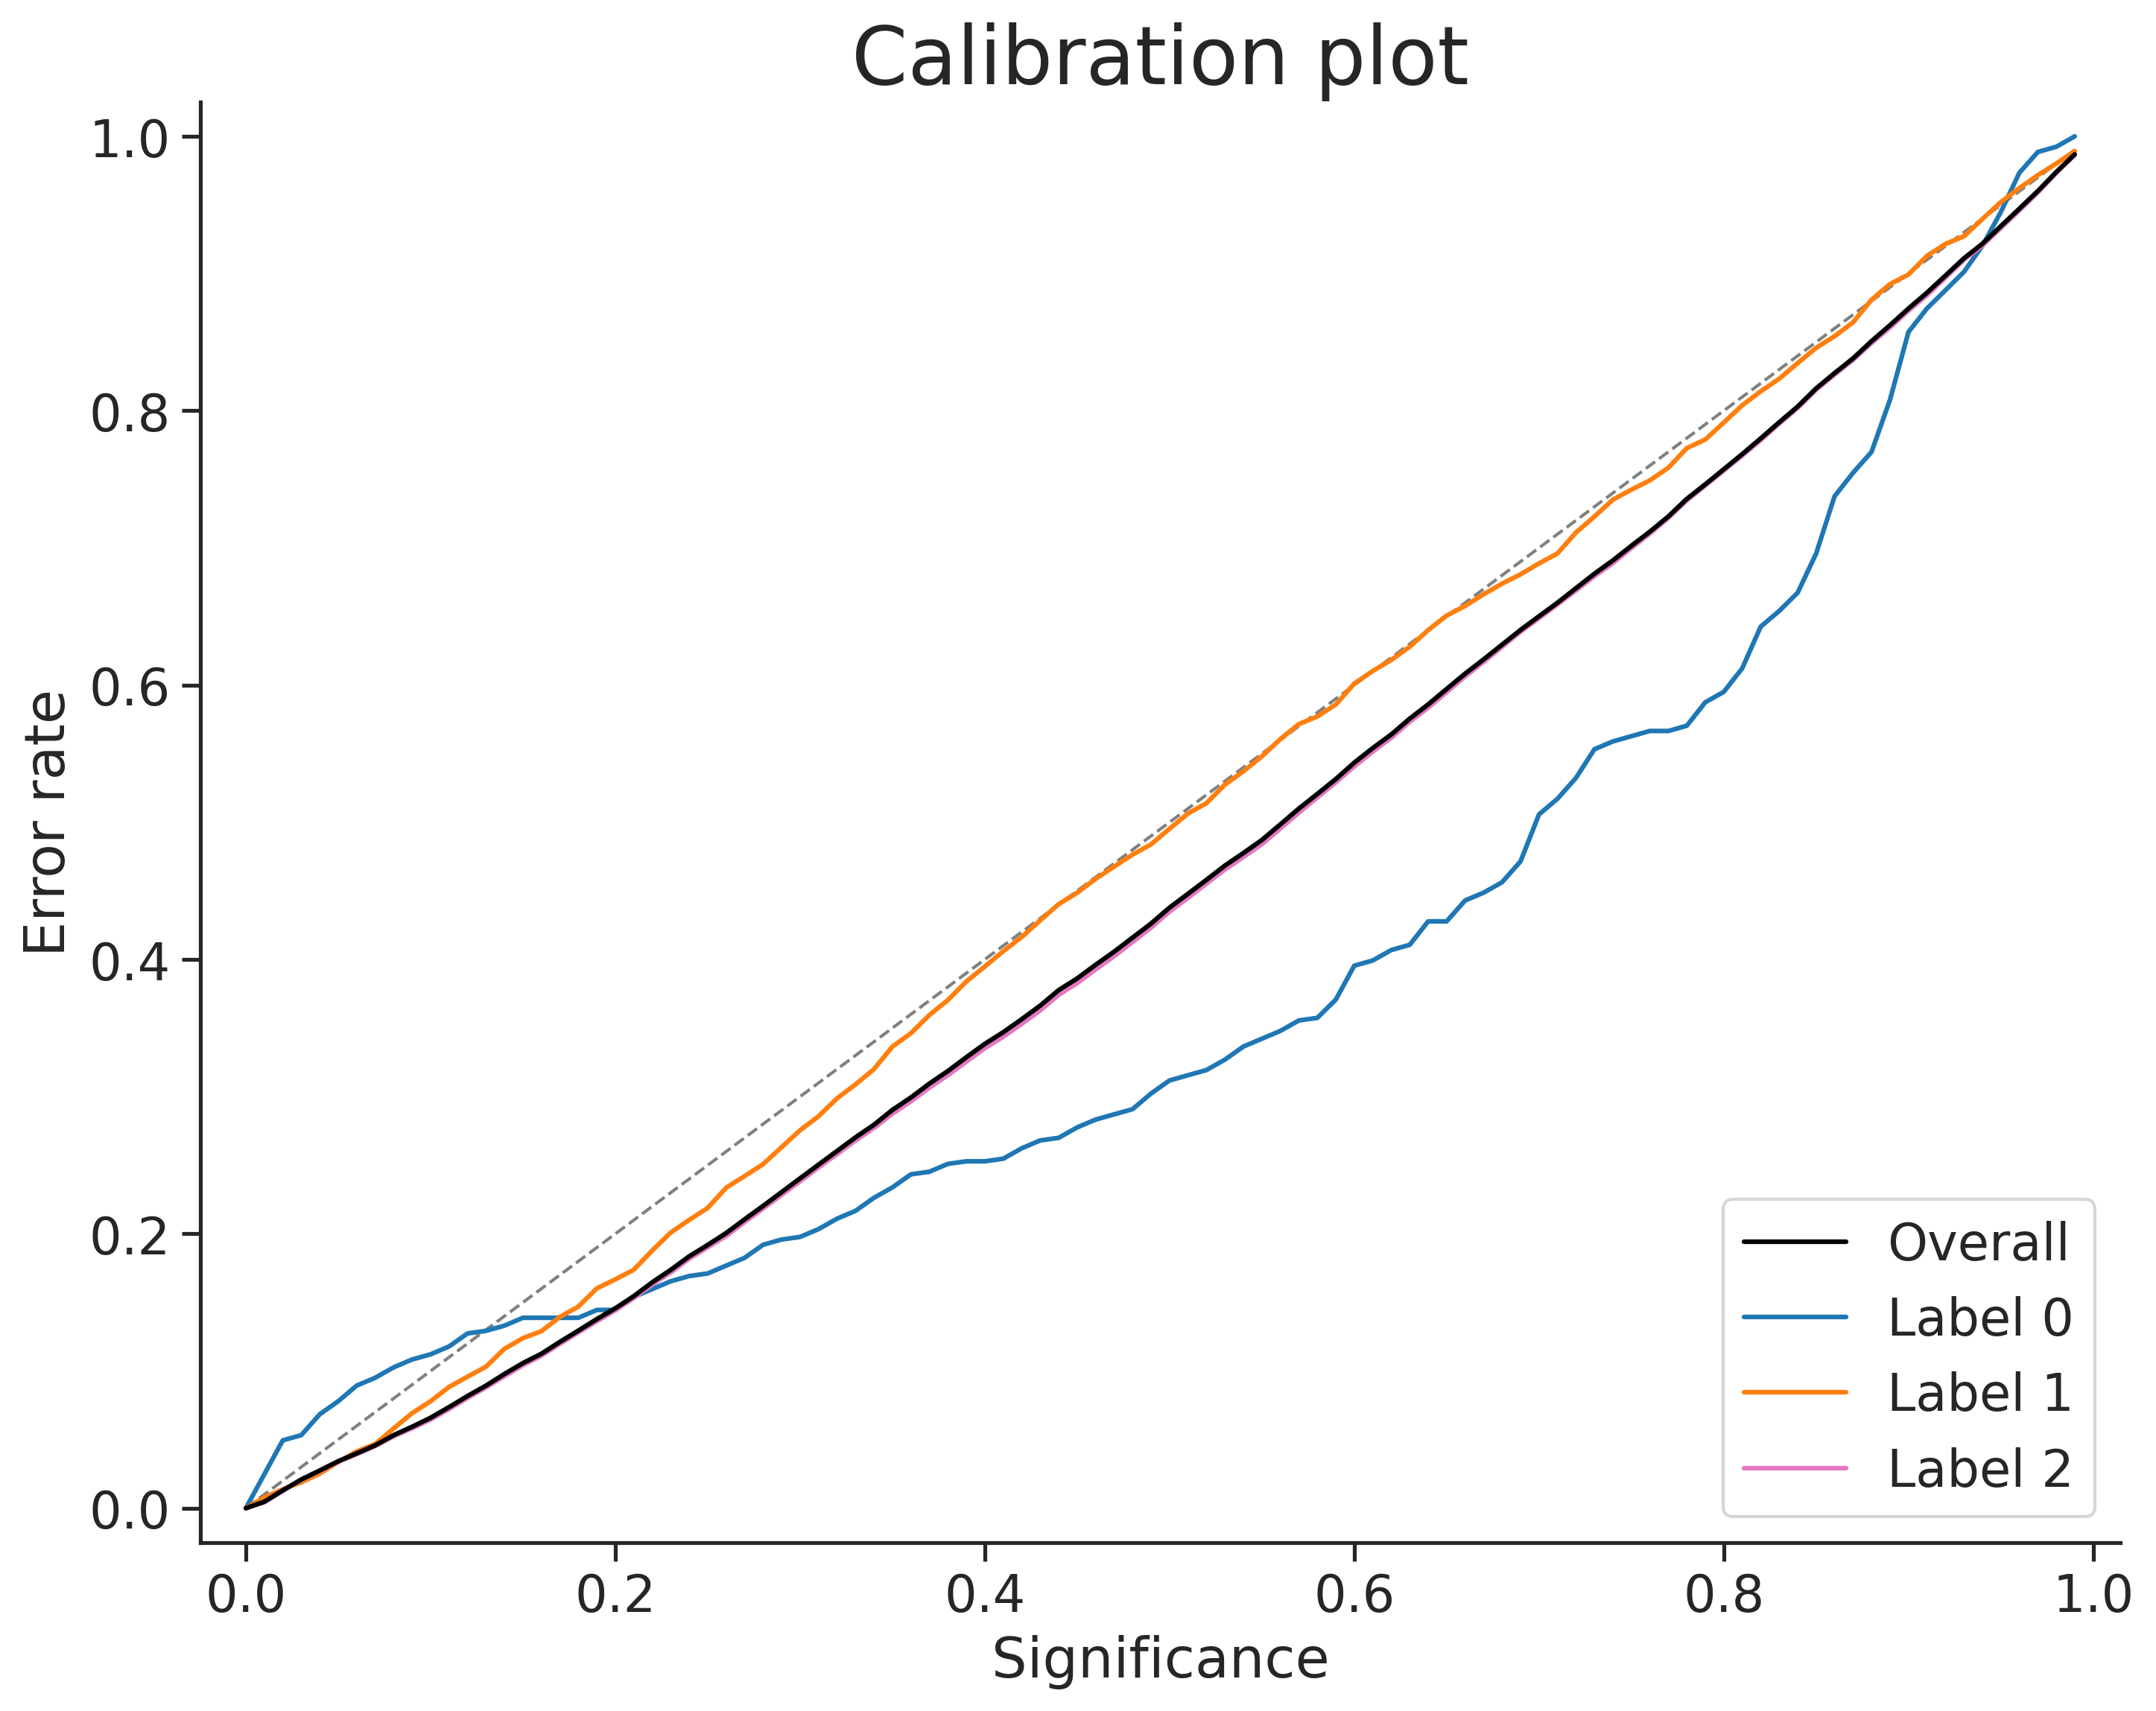

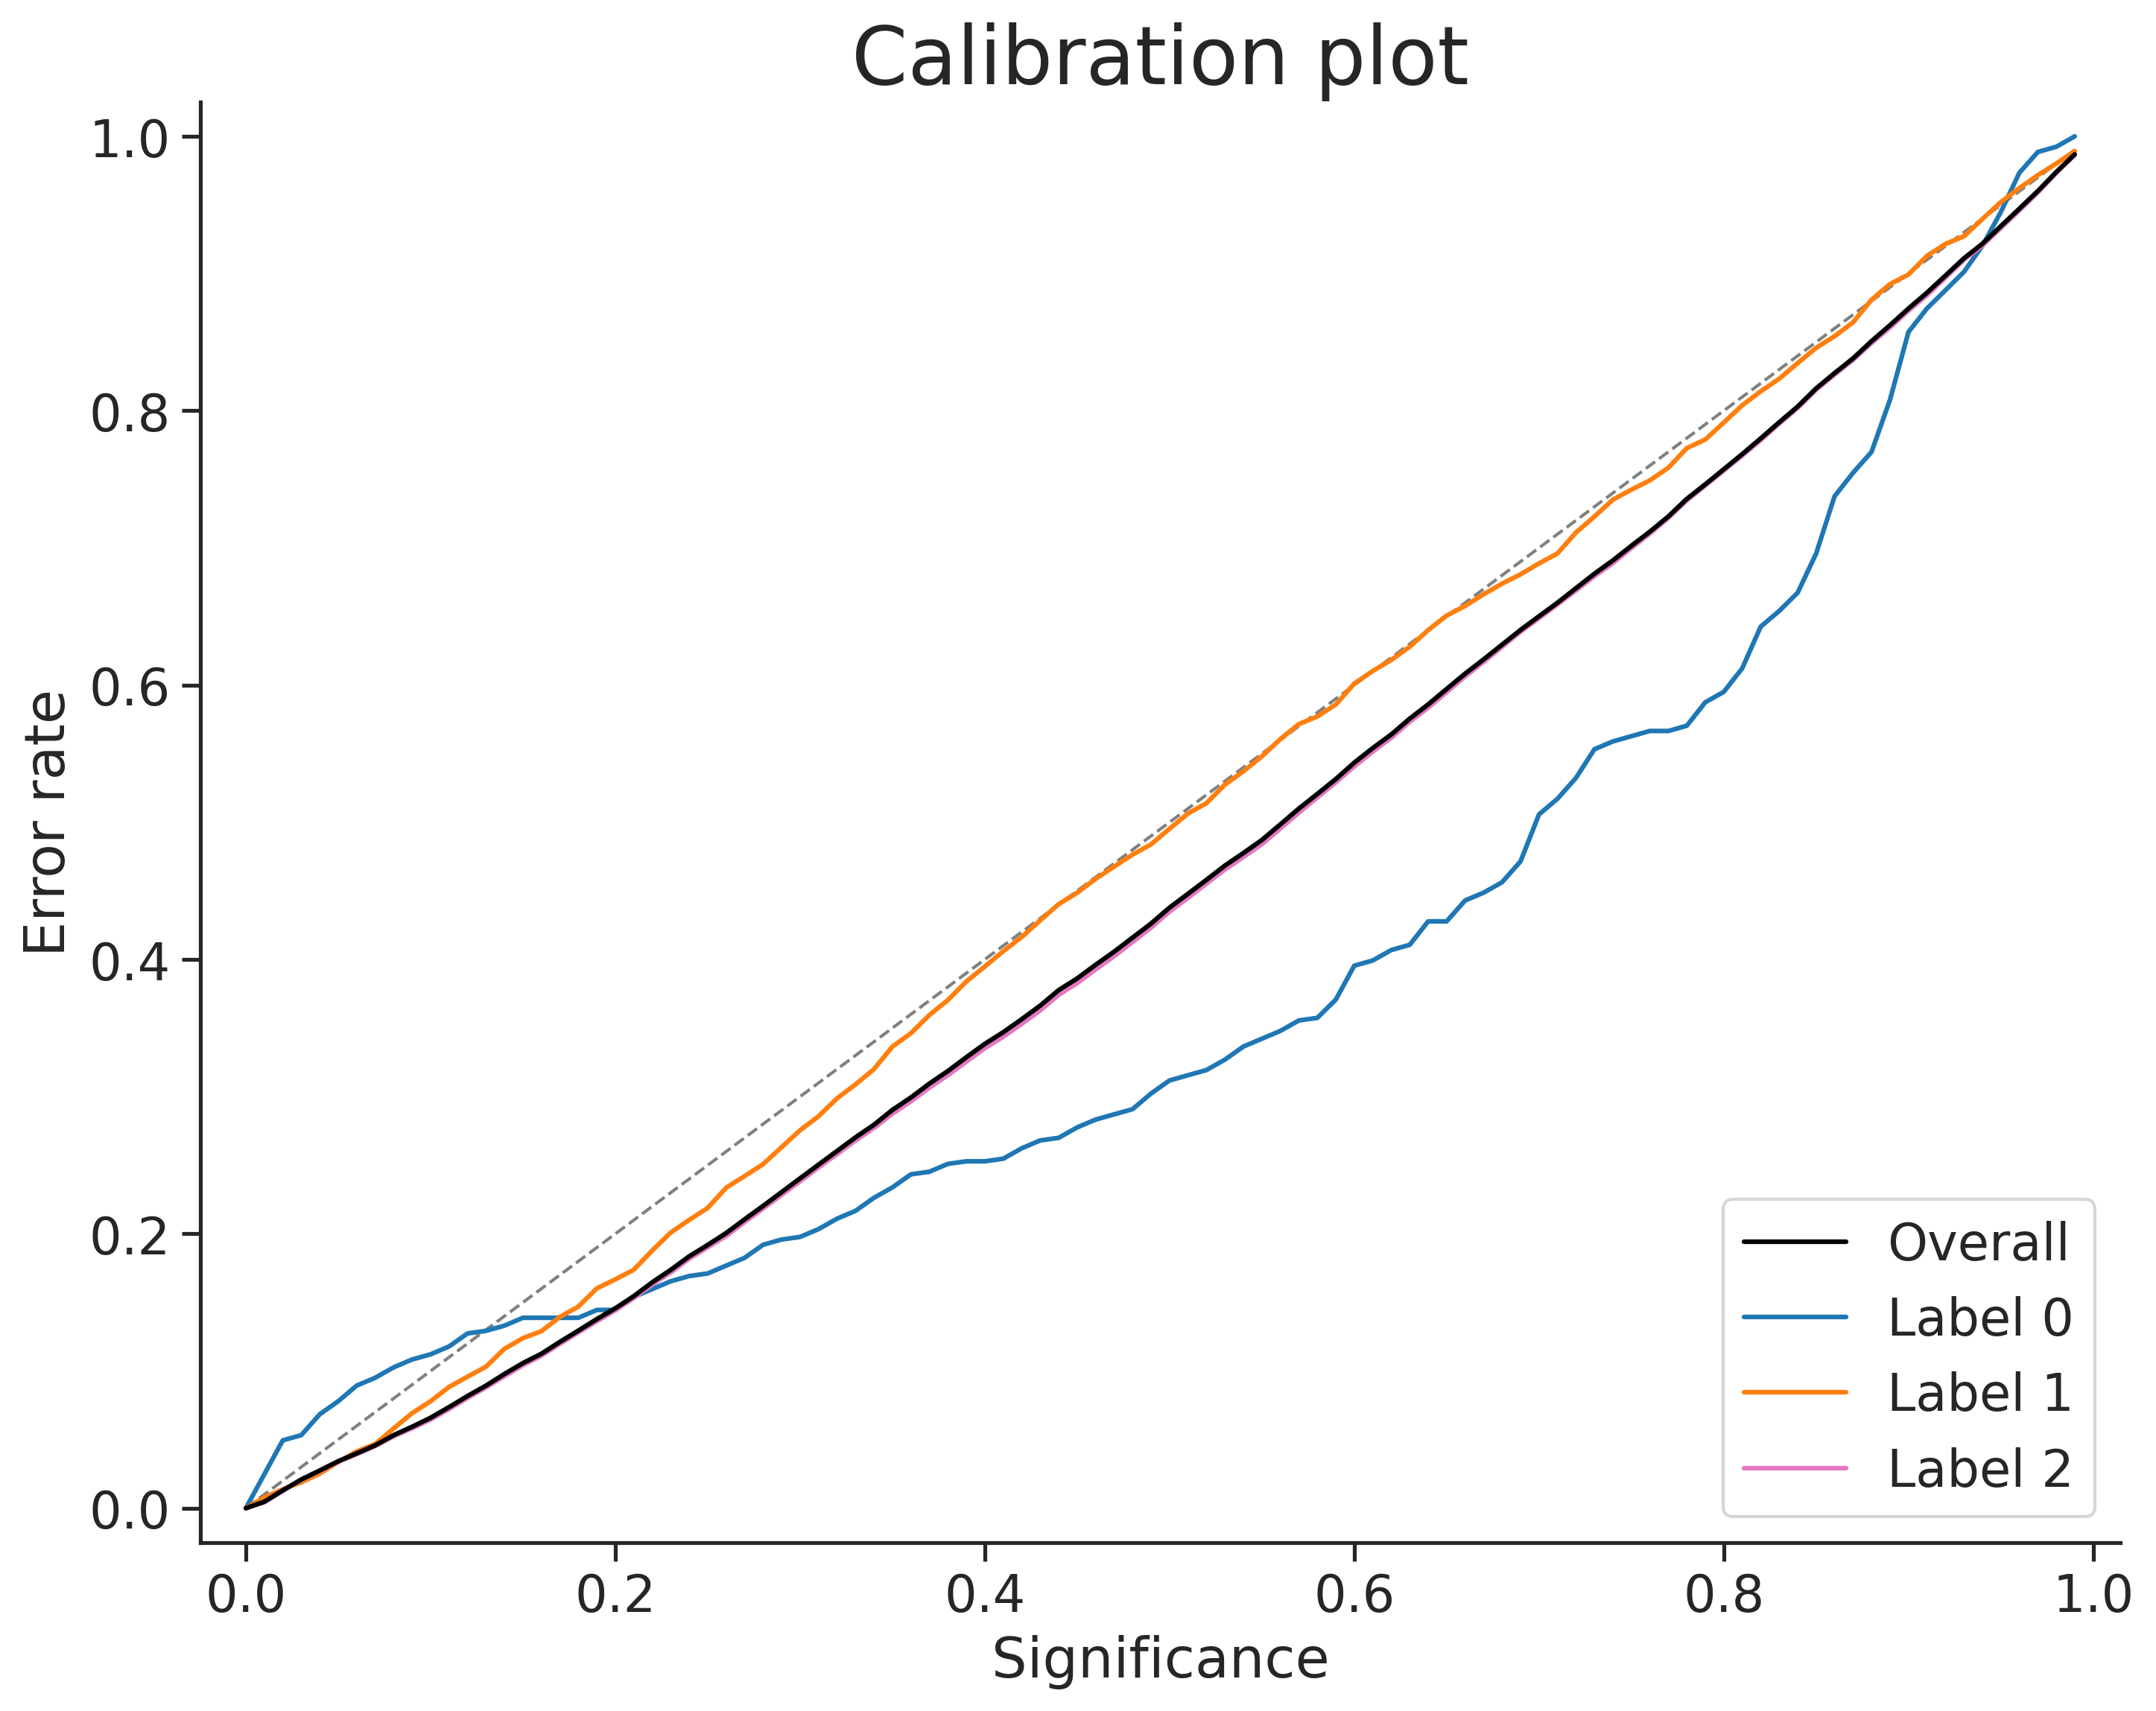

In [28]:
plot.plot_calibration_clf(test_y_encoded, prediction_p_class_cond, title='Calibration plot')

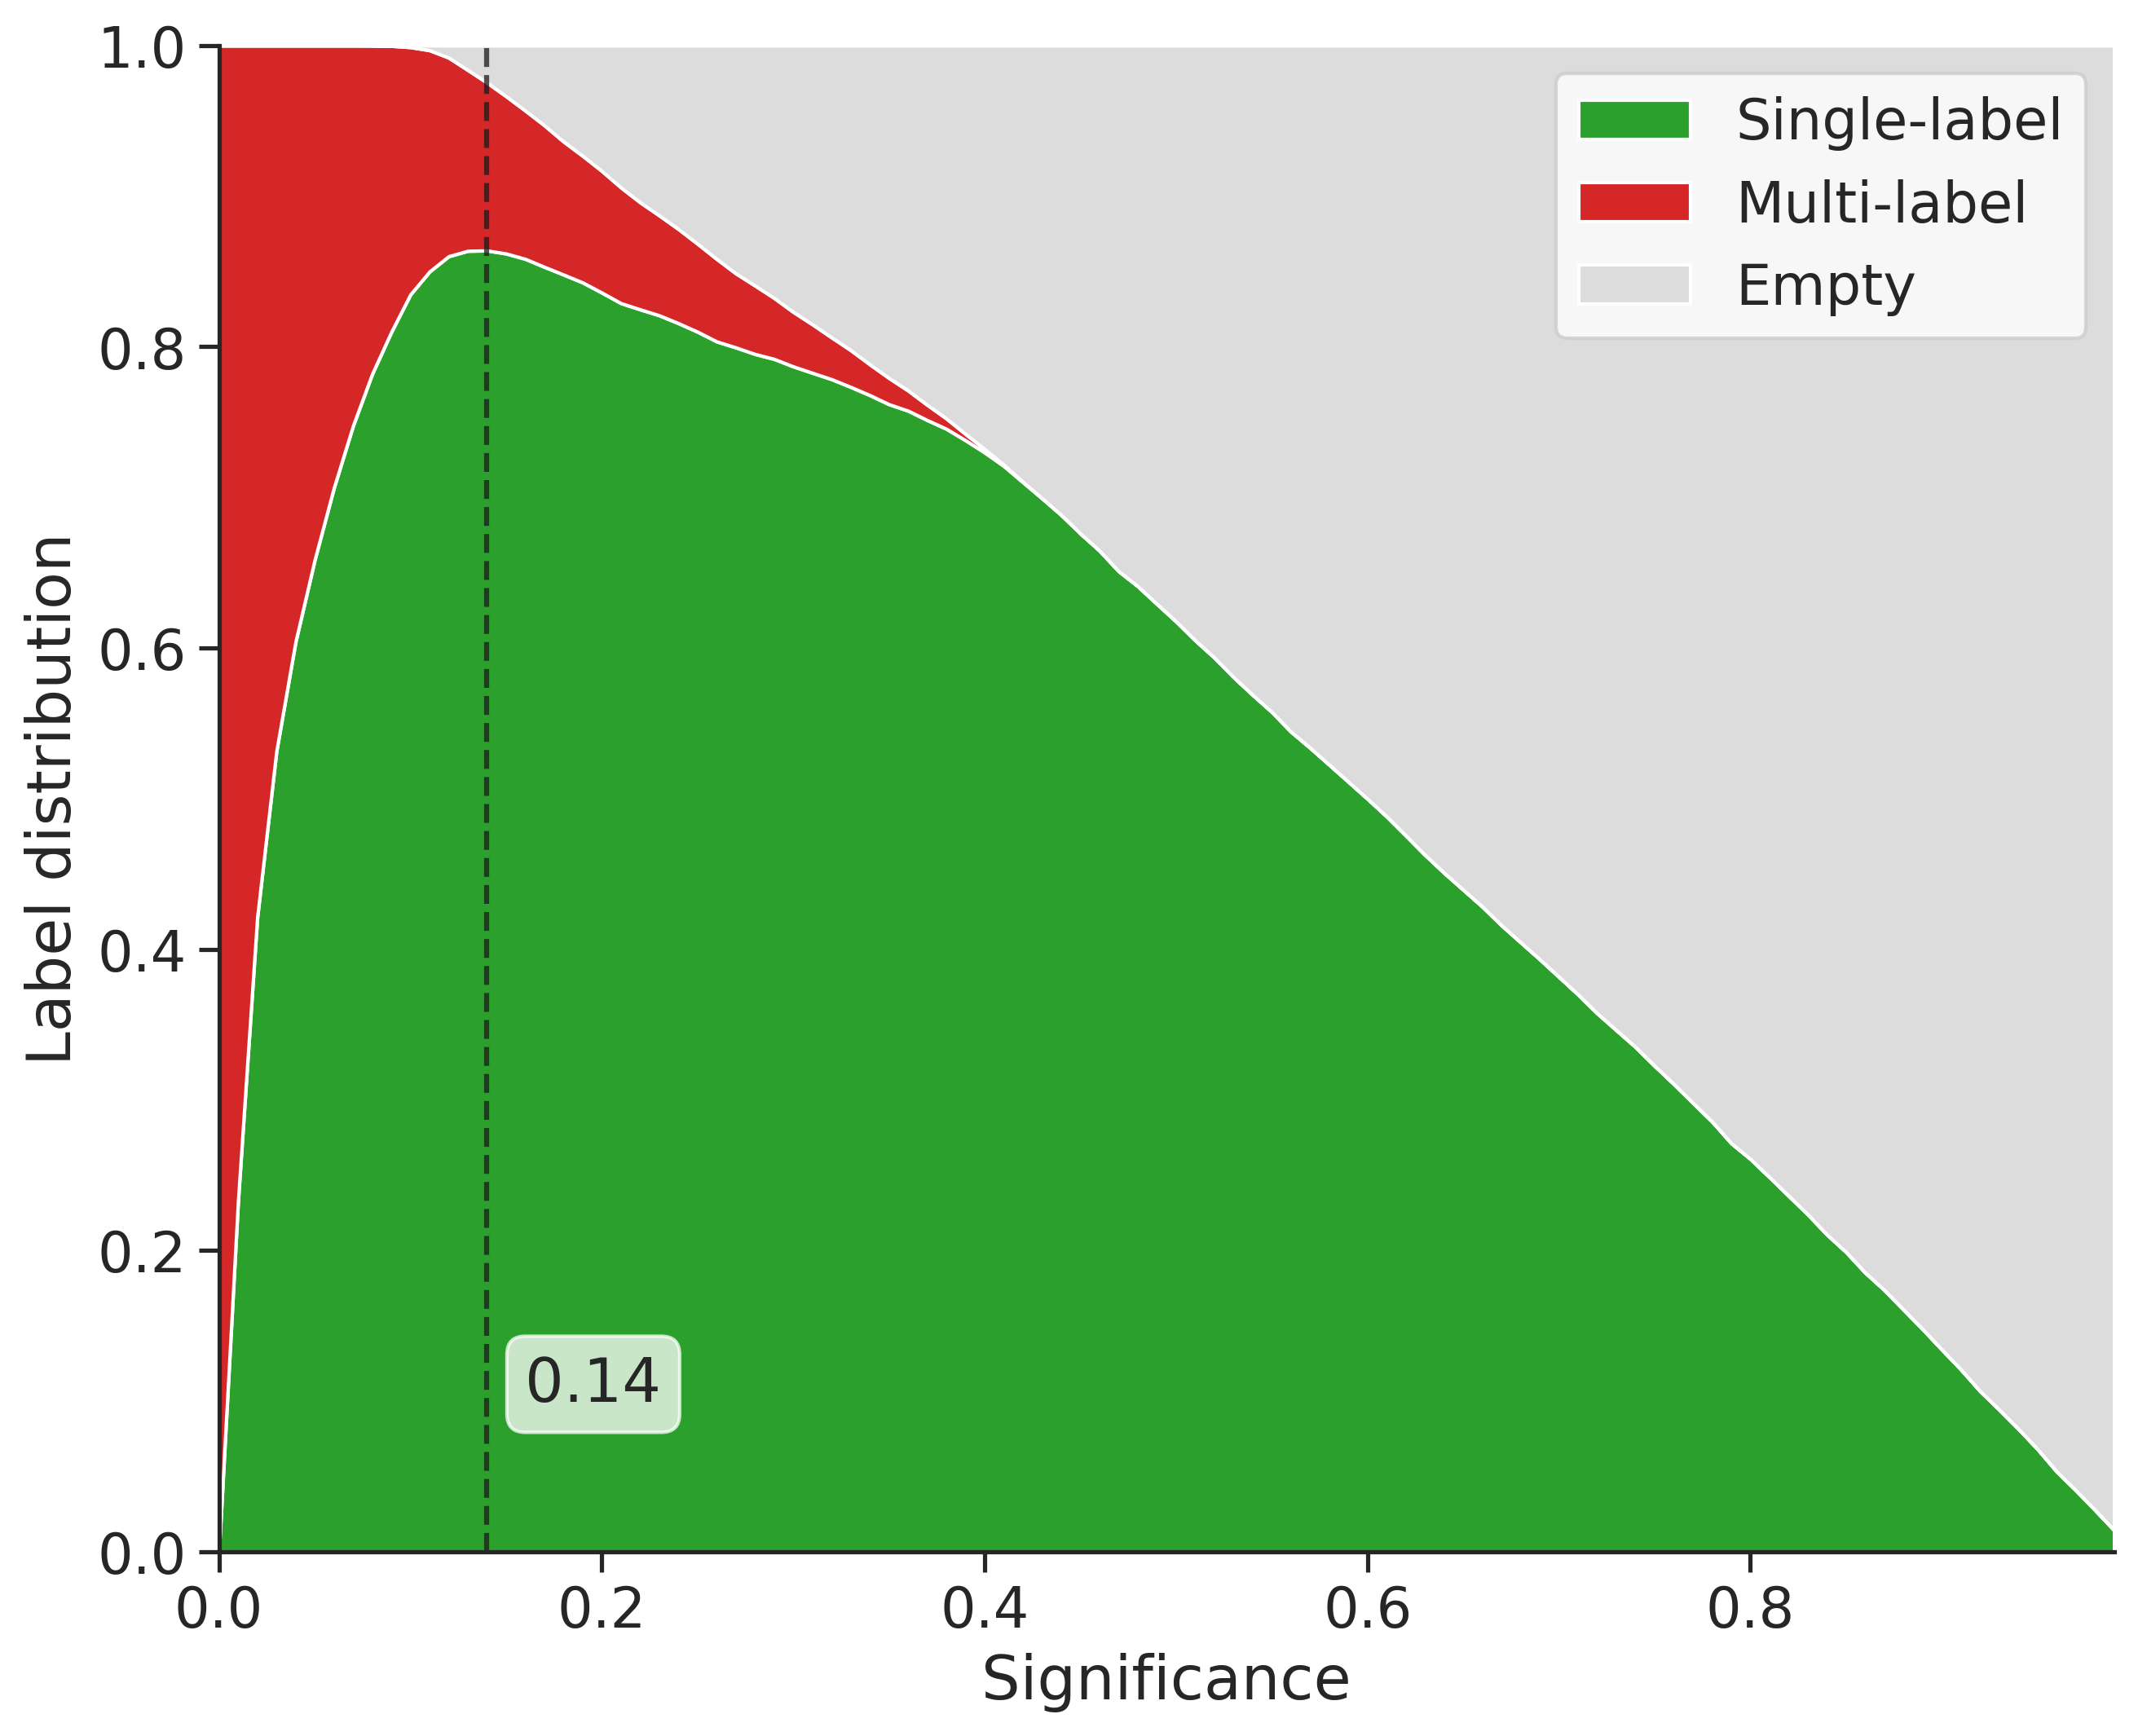

In [29]:
fig = plot.plot_label_distribution(y_true=test_y_encoded,p_values=prediction_p_mond_scoring, tight_layout=False)


In [30]:
class_labels = label_encoder.classes_
class_labels


array(['high_tox_plp', 'low_plp', 'no_plp'], dtype=object)

In [31]:
from conf_eval import metrics
CM = metrics.confusion_matrix(test_y_encoded, prediction_p_mond_scoring, sign=0.1, labels=class_labels)


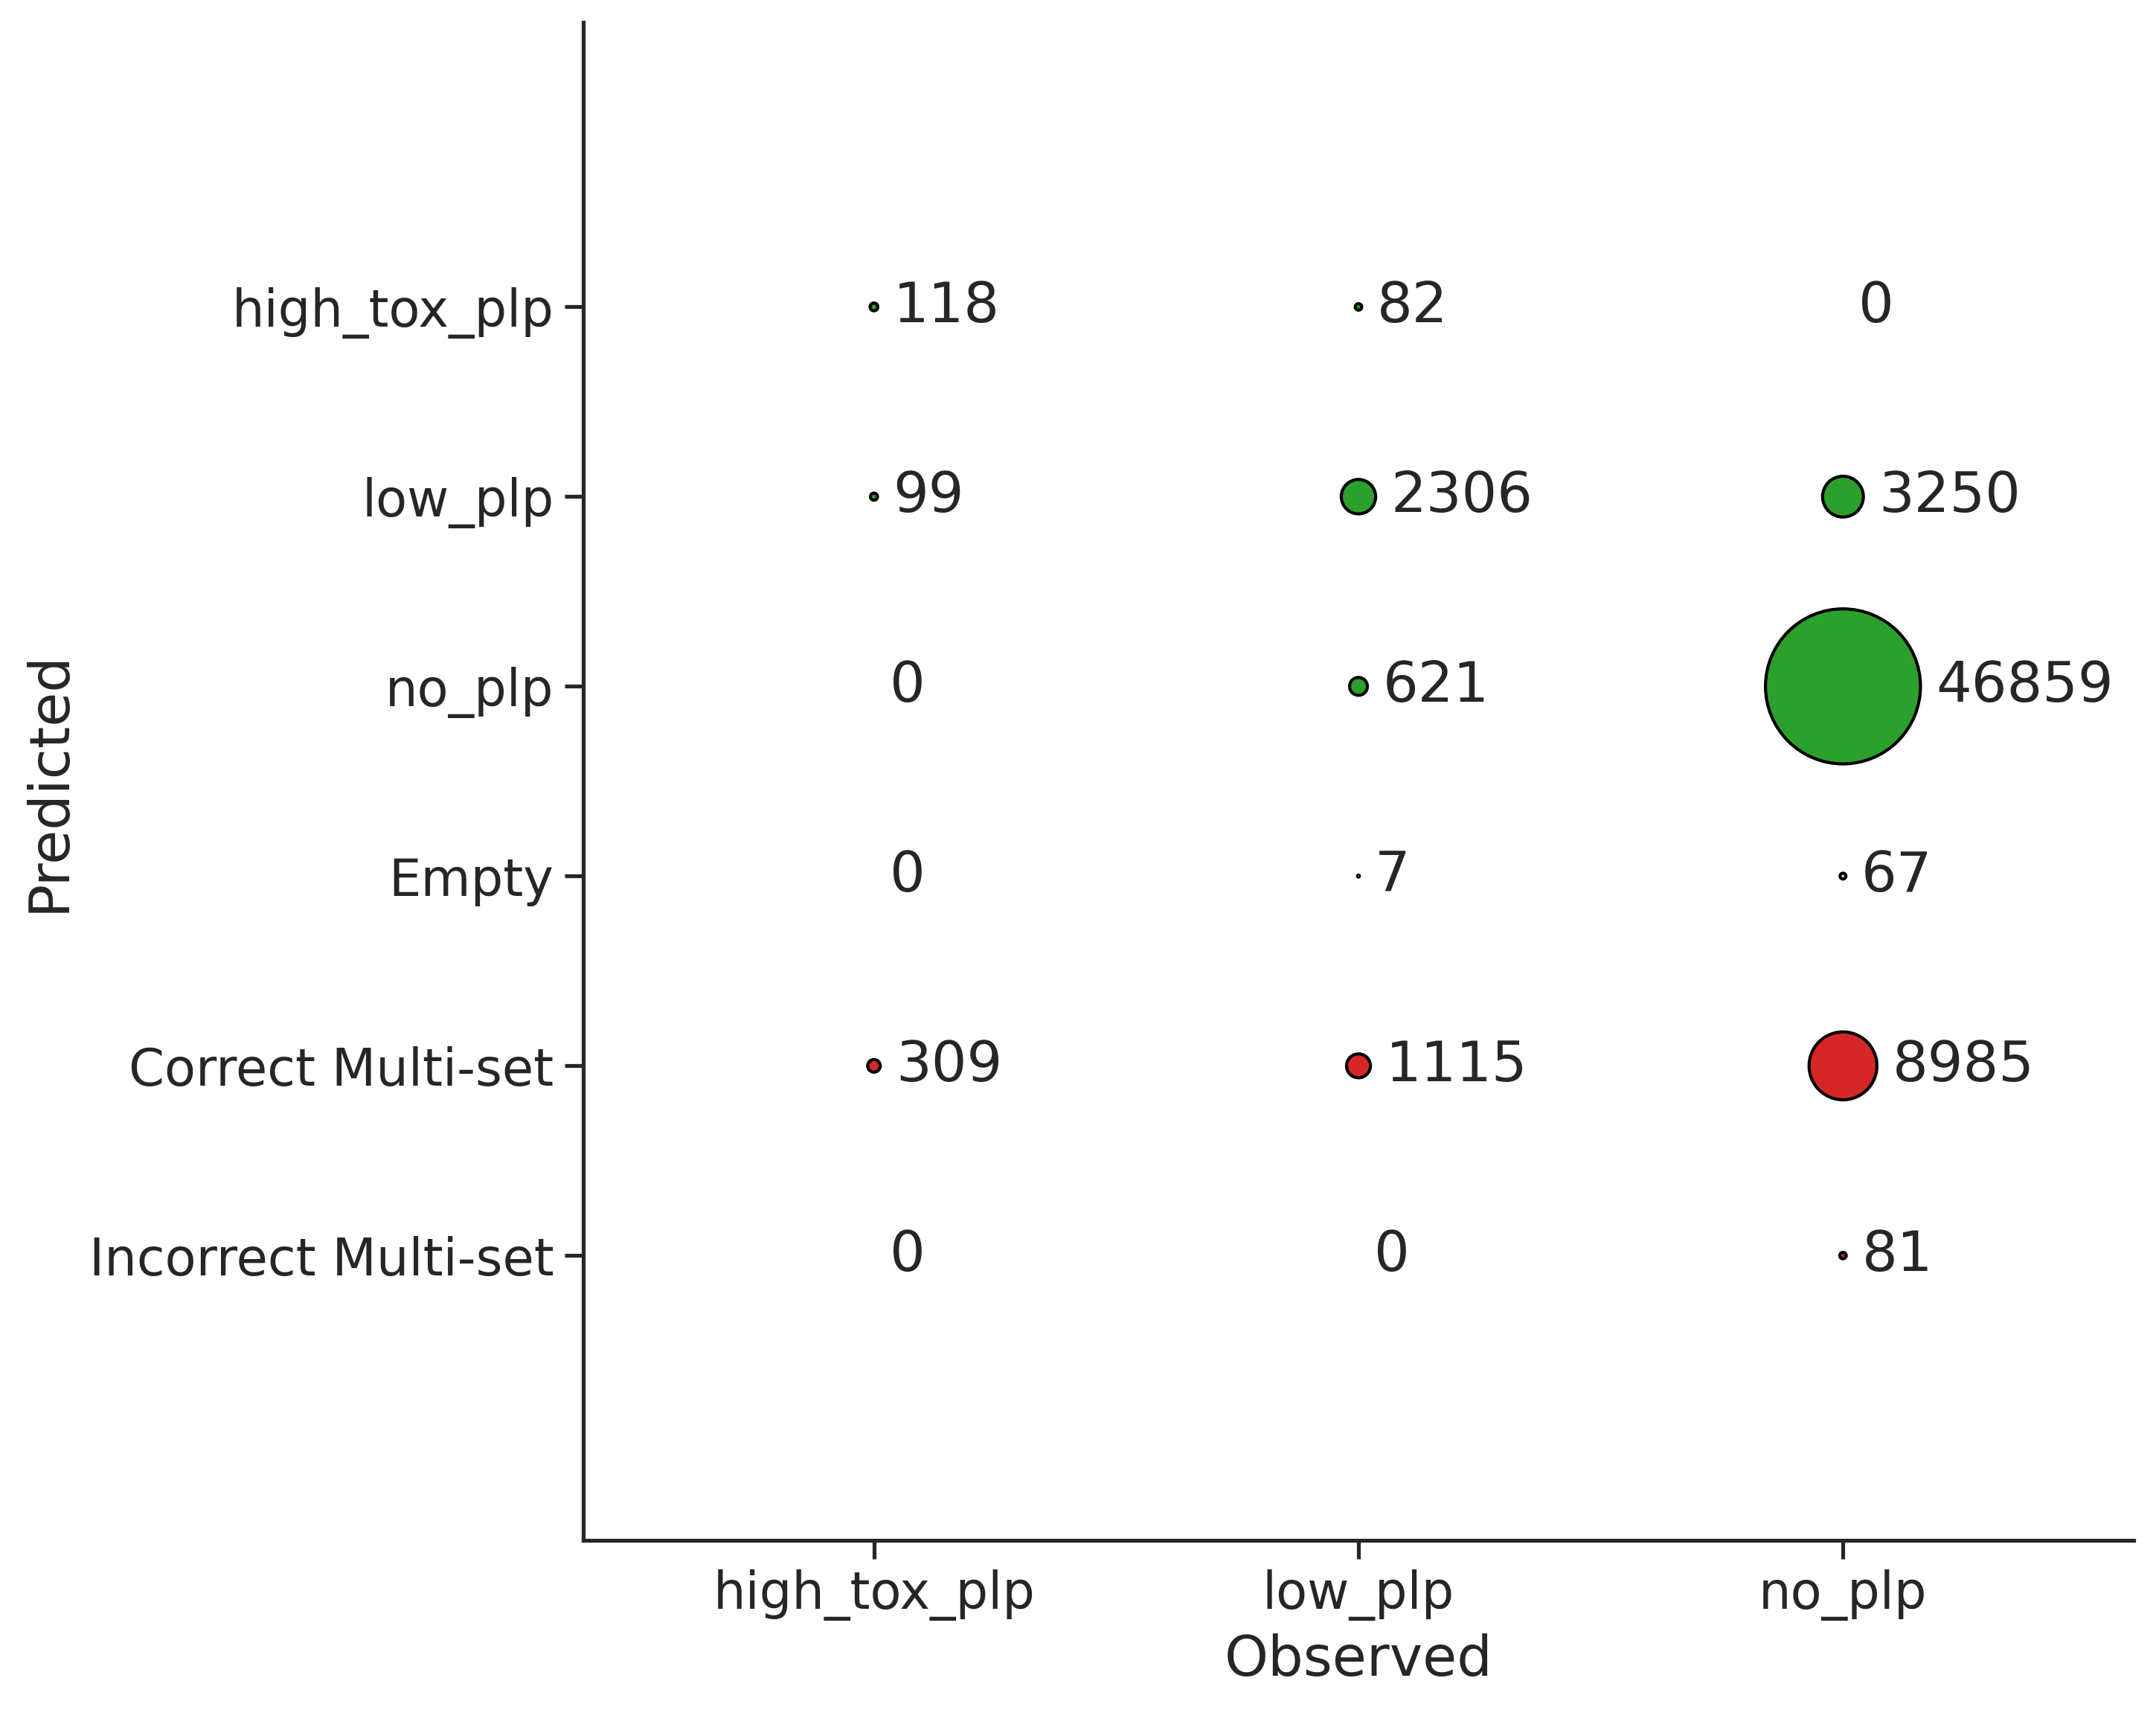

In [32]:
bubble_plot = plot.plot_confusion_matrix_bubbles(confusion_matrix=CM)


In [33]:
print(rf.evaluate(test_X, test_y_encoded, confidence=0.9))
print(rf_mond.evaluate(test_X, test_y_encoded, confidence=0.9))
print(rf_mond_scoring.evaluate(test_X, test_y_encoded, confidence=0.9))



{'error': 0.06266138750215189, 'avg_c': 1.194744831687507, 'one_c': 0.8052551683124931, 'empty': 0.0, 'time_fit': 0.0022165775299072266, 'time_evaluate': 27.797815561294556}
{'error': 0.07068968215465032, 'avg_c': 1.0815662216936102, 'one_c': 0.8354434341695488, 'empty': 0.041628194494436534, 'time_fit': 0.003581523895263672, 'time_evaluate': 30.379907846450806}
{'error': 0.06583827602935888, 'avg_c': 1.1629915961126152, 'one_c': 0.8346922487049876, 'empty': 0.00117372728837697, 'time_fit': 0.0055353641510009766, 'time_evaluate': 15.239136934280396}


In [34]:
#adata.write('/home/jovyan/share/data/analyses/PLP/CP/adata_mad_site_specs5k_CP.h5ad')